In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bigbrain.csv to bigbrain.csv


In [ ]:
asar = "/content/bigbrain.csv"
asar.encode('utf-8').strip()

b'/content/bigbrain.csv'

In [ ]:
record = pd.read_csv(asar, encoding= 'unicode_escape')

In [ ]:
print(record.Animaltype.unique())

['Cattle' 'Pigeon' 'Elephant' 'Squirrel' 'Snake' 'Dog' 'Monkey' 'Peacock'
 'Horse' 'Carnivorous' 'Bird' 'Hen' 'Cat' 'Rabbit' 'Pig' 'Donkey']


In [ ]:
import numpy as np
import pandas as pd
seed = 69 # set random seed for whole document

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

# Natural Language Processing Thingamajibs
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec, word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import gensim

# Classifiers
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Lifesaver
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
asar = "/content/bigbrain.csv"
df = pd.read_csv(asar, encoding= 'unicode_escape')

In [ ]:
df.rename(columns={'Timestamp':'TS',
                   'Description of the situation the animal is in':'MAIN_DESCRIPTION',
                   'Animaltype':'AT',
                   'TypeOfSituation':'HELP'
                  },inplace=True)




In [ ]:
df['SERVICE_TYPE'] = df[['HELP','AT']].agg('-'.join, axis=1)

In [ ]:
df_product_and_complaint = df[['SERVICE_TYPE', 'MAIN_DESCRIPTION']]

In [ ]:
df_product_and_complaint.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SERVICE_TYPE      20000 non-null  object
 1   MAIN_DESCRIPTION  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [ ]:
df_product_and_complaint.SERVICE_TYPE.value_counts()

Illegal_Pet_Shop-Pigeon                       188
Weak_Underfed_Malnourished-Horse              183
Illegal_Possession_of_Exotic_Animal-Pigeon    181
Rescue-Donkey                                 181
Cruelty_Complaint-Pigeon                      180
                                             ... 
Lost_Displaced_Abandoned-Bird                 121
Rescue-Squirrel                               120
Illegal_Breeding-Cat                          115
Weak_Underfed_Malnourished-Rabbit             110
Neutering-Rabbit                              109
Name: SERVICE_TYPE, Length: 133, dtype: int64

In [ ]:
# Applying encoding to the PRODUCT column
df_product_and_complaint['S_ID'] = df_product_and_complaint['SERVICE_TYPE'].factorize()[0]
#factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the service_type column

# Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
category_id_df = df_product_and_complaint[['SERVICE_TYPE', 'S_ID']].drop_duplicates()

# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a service_type: S_ID key-value pair
id_to_category = dict(category_id_df[['S_ID', 'SERVICE_TYPE']].values)  # Creates a S_ID: SERVICE_TYPE key-value pair

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_product_and_complaint.head(10)

,SERVICE_TYPE,MAIN_DESCRIPTION,S_ID
0,Cruelty_Complaint-Cattle,There is a lot of commotion going on recently...,0
1,Injured_Sick-Pigeon,I feel uneasy even trying to think about all ...,1
2,Weak_Underfed_Malnourished-Elephant,It has been many years since I moved here and...,2
3,Rescue-Cattle,I feel uneasy even trying to think about all ...,3
4,Injured_Sick-Squirrel,I recently moved in to this new area which is...,4
5,Injured_Sick-Snake,It was late at night when I was coming back f...,5
6,Cruelty_Complaint-Pigeon,The place is not the same as it used to be be...,6
7,Weak_Underfed_Malnourished-Dog,I recently moved in to the neighbourhood and ...,7
8,Lost_Displaced_Abandoned-Elephant,An unexpected turn of events had made me to t...,8
9,Cruelty_Complaint-Monkey,The place is not the same as it used to be be...,9


In [ ]:
## Pickling reduced dataframe
with open('df_product_and_complaint.pickle', 'wb') as to_write:
   pickle.dump(df_product_and_complaint, to_write)

In [ ]:
# Loading Pickled DataFrame
with open('df_product_and_complaint.pickle', 'rb') as to_read:
    df_product_and_complaint = pickle.load(to_read)

In [ ]:
# Reviewing our Loaded Dataframe
print(df_product_and_complaint.info())
print('--------------------------------------------------------------------------------------')
print(df_product_and_complaint.head().to_string())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SERVICE_TYPE      20000 non-null  object
 1   MAIN_DESCRIPTION  20000 non-null  object
 2   S_ID              20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 468.9+ KB
None
--------------------------------------------------------------------------------------
                          SERVICE_TYPE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
# Looking at a sample text
sample_complaint = list(df_product_and_complaint.MAIN_DESCRIPTION[:5])[4]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint = []
list_sample_complaint.append(sample_complaint)
list_sample_complaint

[" I recently moved in to this new area which is still under development. There are a lot of Squirrels moving about. They cause nuisance and shriek through nights sometimes. I live near Hosa Road, in an apartment near the Police Station over there.  It couldn't stand properly. This poor Squirrel is injured badly from what looks like an accident."]

In [ ]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf3 = TfidfVectorizer(stop_words='english')
check3 = tf_idf3.fit_transform(list_sample_complaint)

print(tf_idf3.get_feature_names())

['accident', 'apartment', 'area', 'badly', 'cause', 'couldn', 'development', 'hosa', 'injured', 'like', 'live', 'looks', 'lot', 'moved', 'moving', 'near', 'new', 'nights', 'nuisance', 'police', 'poor', 'properly', 'recently', 'road', 'shriek', 'squirrel', 'squirrels', 'stand', 'station']


In [ ]:
# Split the data into X and y data sets
X, y = df_product_and_complaint.MAIN_DESCRIPTION, df_product_and_complaint.SERVICE_TYPE
print('X shape:', X.shape, 'y shape:', y.shape)
# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (20000,) y shape: (20000,)
X_train (16000,)
y_train (16000,)
X_test (4000,)
y_test (4000,)


In [ ]:
# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

In [ ]:
# Initializing our chosen logreg model
logit = LogisticRegression()

# Fitting our model
logit_finalized = logit.fit(X_train_val_tfidf1, y_train_val)

# Obtaining prediction
y_pred = logit_finalized.predict(X_test_tfidf1)

In [ ]:
X, y = df_product_and_complaint.MAIN_DESCRIPTION, df_product_and_complaint.SERVICE_TYPE
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')
fitted_tfidf_to_use = tfidf.fit(X_train_val)

In [ ]:
with open('fitted_tfidf_to_use_MAIN.pickle', 'wb') as to_write:
  pickle.dump(fitted_tfidf_to_use, to_write)

In [ ]:
 # Pickle trained Model for use in Flask App
 with open('logit_finalized_MAIN.pickle', 'wb') as to_write:
     pickle.dump(logit_finalized, to_write)

In [ ]:
# Now we have a pickled trained model, we can use this for our flask app!
with open('logit_finalized_MAIN.pickle', 'rb') as to_read:
    logit_finalized = pickle.load(to_read)

In [ ]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    
    # Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
    category_id_df = df_product_and_complaint[['SERVICE_TYPE', 'S_ID']].drop_duplicates()

    # Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
    category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
    id_to_category = dict(category_id_df[['S_ID', 'SERVICE_TYPE']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g= sns.heatmap(conf_mat, 
                   annot=True, annot_kws={"size":10},
                   cmap=plt.cm.Reds, square=True,
                   fmt='d',
                   xticklabels=category_id_df.PRODUCT.values, 
                   yticklabels=category_id_df.PRODUCT.values)
    
#     # Changing the size of the xticks and ytick labels
#     ax.set_yticklabels(g.get_yticklabels(), rotation=90, size=10);
#     ax.set_xticklabels(g.get_xticklabels(), size=10);
    
    # Changing axis orientation & setting titles
    ax.set_xlabel('Prediction', size=15)
    ax.set_ylabel('Actual', rotation=0, labelpad=40,size=15)

#     plt.title("CONFUSION MATRIX - {}\n".format(name), size=16);
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

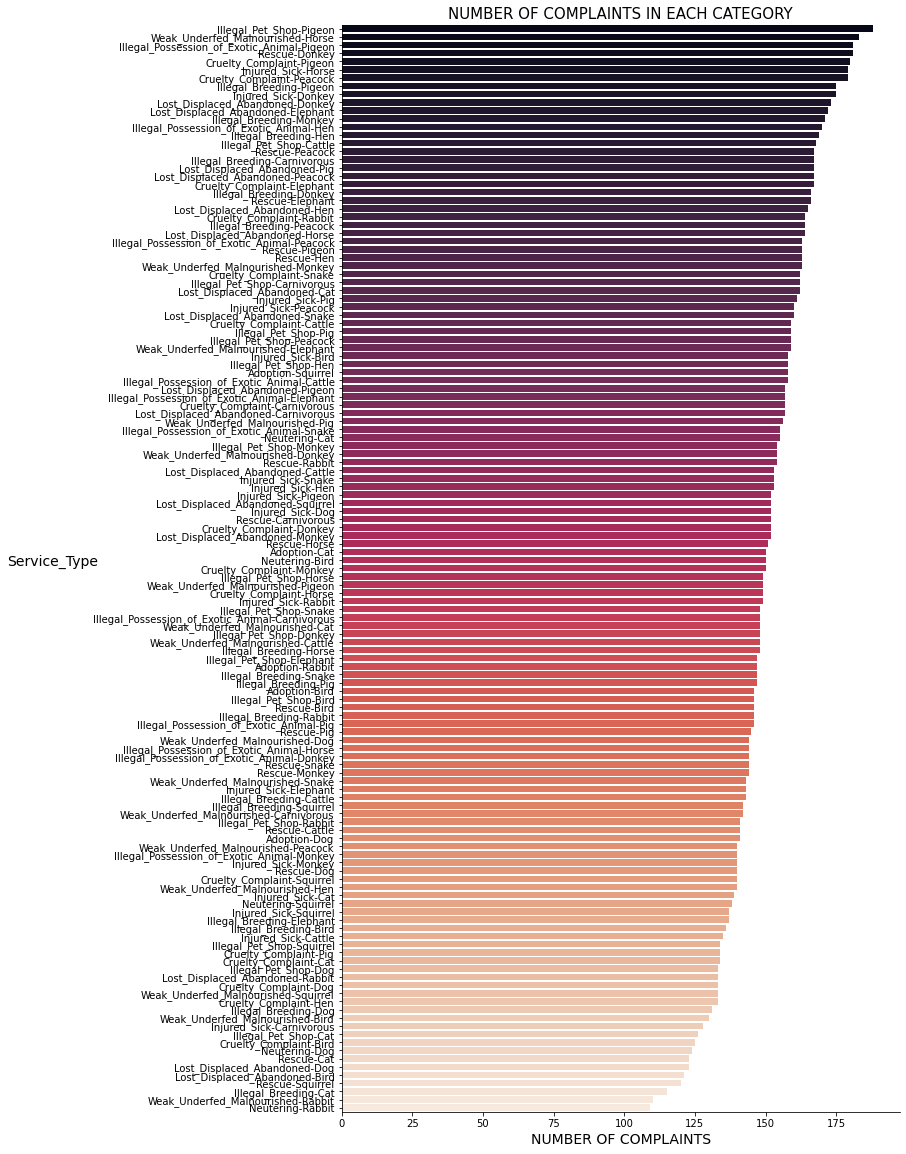

In [ ]:
fig, ax = plt.subplots(figsize=(10,20))

ax = sns.countplot(y='SERVICE_TYPE', 
                   data=df_product_and_complaint, 
                   order=df_product_and_complaint['SERVICE_TYPE'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('Service_Type', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes.png', transparency=True)

In [ ]:

# These are the ONLY packages we need to use from this point forward!
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.linear_model as lm

In [ ]:
# Loading our saved models
# Consider training on the whole data instead now?
with open('fitted_tfidf_to_use_MAIN.pickle', 'rb') as to_read:  # loading the fitted tfidf with our 80% trained data
    fitted_tfidf_to_use = pickle.load(to_read)
    
with open('logit_finalized_MAIN.pickle', 'rb') as to_read:  # loading our model
    logit_finalized = pickle.load(to_read)

In [ ]:
# Using our models

complaint = "peacock has entered my apartment might get poached"

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint = fitted_tfidf_to_use.transform([complaint])
print(new_vectorized_complaint)
# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint)
print(y_customized_prediction[0])


  (0, 465)	0.8498404083585189
  (0, 25)	0.5270401126299835
Rescue-Peacock
